![headerimage](../images/header_image.png)

## Overview

Your company would like to start a movie studio and is asking us to recommend the best way foward. The main objective of this project is to produce three actionable recommendations for your company to take into consideration. With these recommendations your company can create their own *successful* movie studio.

### Data 

The data is sourced from various movie data websites online:
> - Box Office Mojo
> - Format: csv 
> - IMDB
> - Format: Database
> -  The Numbers
> - Format: csv

We joined all the relevant data as tables into the IMDB database in the exploratory notebook for easier access and analysis. 

### Methods

This project utilizes python for exploratory data analysis and python along with SQL for interacting with the data in the databases. 



In [1]:
# import neeeded libraries
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

Load in the data.

In [2]:
# open connection to the database
conn = sqlite3.connect('../zippedData/im.db')

In [3]:
# take a look at the tables in the database
pd.read_sql("""

SELECT name
FROM sqlite_master
WHERE type = "table"

""", conn)

,name
0,movie_basics
1,directors
2,known_for
3,movie_akas
4,movie_ratings
5,persons
6,principals
7,writers
8,box_office_mojo
9,tn_movie_budgets


The database includes 10 tables with movie data that will be very helpful in our analysis.

## Average Profit Percentage by Genres

In [4]:
basics_budgets = pd.read_sql("""

SELECT *   
FROM movie_basics AS m
JOIN tn_movie_budgets AS t
        ON m.primary_title = t.movie
GROUP BY genres

""", conn)

# splits genres values by the comma to create list
basics_budgets['genres'] = basics_budgets['genres'].str.split(',')

# for each movie creates a record for each genre 
basics_budgets = basics_budgets.explode('genres')

# change worldwide gross column to type int
basics_budgets['worldwide_gross'] = basics_budgets['worldwide_gross'].replace('[\$,]', '', regex=True).astype(int)
basics_budgets['production_budget'] = basics_budgets['production_budget'].replace('[\$,]', '', regex=True).astype(int)
basics_budgets['avg_profit_perc'] = basics_budgets['worldwide_gross'] / basics_budgets['production_budget']

# group by genres and select profit for that genre
genre_by_profit = basics_budgets.groupby('genres')['avg_profit_perc'].mean().sort_values(ascending = False).to_frame()
genre_by_profit = genre_by_profit.reset_index()

In [5]:
genre_by_profit

,genres,avg_profit_perc
0,Family,3.831503
1,Thriller,3.796146
2,Crime,3.641379
3,Fantasy,3.309361
4,Drama,3.250494
5,Horror,3.246080
6,Musical,2.778568
7,Animation,2.707194
8,Romance,2.690754
9,News,2.626353


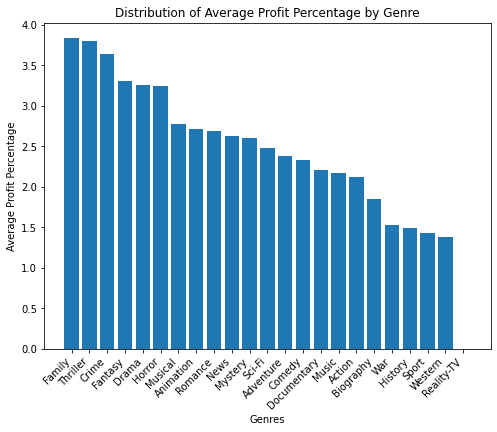

In [6]:
# Create figure
fig, ax = plt.subplots(figsize = (8,6))

# Create the line plot
# sns.lineplot(data=genre_by_profit, ax = ax)
plt.bar(data = genre_by_profit, x =genre_by_profit['genres'], height=genre_by_profit['avg_profit_perc'])
# Set the x-axis tick positions and labels
plt.xticks(range(len(genre_by_profit['genres'])), genre_by_profit['genres'], rotation=45, ha='right')

# Add labels and title
plt.xlabel('Genres')
plt.ylabel('Average Profit Percentage')
plt.title('Distribution of Average Profit Percentage by Genre')


# Show the plot
plt.show()

## Popular Directors, Writers and Actors

In [7]:
# get top directors
directors = pd.read_sql("""

WITH RECURSIVE split(genre, str) AS (
    SELECT '', genres || ',' FROM movie_basics
    UNION ALL SELECT
    substr(str, 0, instr(str, ',')),
    substr(str, instr(str, ',')+1)
    FROM split WHERE str!=''
)
SELECT DISTINCT 
                p.primary_name AS director,
                AVG(CAST(REPLACE(REPLACE(t.worldwide_gross, '$', ''), ',', '') AS INT)) / 
                                AVG(CAST(REPLACE(REPLACE(t.production_budget, '$', ''), ',', '') AS INT)) AS average_profit_perc
FROM split
JOIN movie_basics AS m
    ON instr(genres, genre) > 0
    
JOIN directors AS d
    ON m.movie_id = d.movie_id
JOIN persons AS p
    ON d.person_id = p.person_id
JOIN tn_movie_budgets AS t
    ON t.movie = m.primary_title
    
WHERE genre!='' AND genre = "Family"
GROUP BY director
ORDER BY average_profit_perc DESC
LIMIT 10    

""", conn)
directors

,director,average_profit_perc
0,Karthik Chandan,124.277880
1,Brandon Camp,63.119120
2,Jesse Rose,19.534452
3,Adam Sputh,19.534452
4,Stephen Chbosky,15.230236
5,Nelson Venkatesan,12.848163
6,Jon Erwin,12.229174
7,Andrew Erwin,12.229174
8,Ravi Punj,11.041042
9,Michael Scordakis,10.884333


In [8]:
# get top writers
writers = pd.read_sql("""

WITH RECURSIVE split(genre, str) AS (
    SELECT '', genres || ',' FROM movie_basics
    UNION ALL SELECT
    substr(str, 0, instr(str, ',')),
    substr(str, instr(str, ',')+1)
    FROM split WHERE str!=''
)

SELECT DISTINCT 
                p.primary_name AS writer,
                AVG(CAST(REPLACE(REPLACE(t.worldwide_gross, '$', ''), ',', '') AS INT)) / 
                                AVG(CAST(REPLACE(REPLACE(t.production_budget, '$', ''), ',', '') AS INT)) AS average_profit_perc
FROM split
JOIN movie_basics AS m
    ON instr(genres, genre) > 0
    
JOIN writers AS w
    ON m.movie_id = w.movie_id
JOIN persons AS p
    ON w.person_id = p.person_id
JOIN tn_movie_budgets AS t
    ON t.movie = m.primary_title
    
WHERE genre!='' AND genre = "Family"
GROUP BY writer
ORDER BY average_profit_perc DESC
LIMIT 10
""", conn)
writers

,writer,average_profit_perc
0,Joe Camp,63.119120
1,Brandon Camp,63.119120
2,Steve Conrad,15.230236
3,R.J. Palacio,15.230236
4,Jack Thorne,15.230236
5,Sankar Dass,12.848163
6,Nelson Venkatesan,12.848163
7,Jon Erwin,12.229174
8,Brent McCorkle,12.229174
9,Bart Millard,12.229174


In [9]:
# get top actors
actors = pd.read_sql("""

SELECT p.primary_name AS actor,
                AVG(CAST(REPLACE(REPLACE(t.worldwide_gross, '$', ''), ',', '') AS INT)) / 
                                AVG(CAST(REPLACE(REPLACE(t.production_budget, '$', ''), ',', '') AS INT)) AS average_profit_perc
FROM persons AS p
    JOIN known_for AS k
        ON p.person_id = k.person_id
    JOIN movie_basics AS m
        ON k.movie_id = m.movie_id
    JOIN tn_movie_budgets AS t
        ON m.primary_title = t.movie
WHERE primary_profession LIKE '%actor%' AND
                genres LIKE '%Family%'
GROUP BY actor
ORDER BY average_profit_perc DESC
LIMIT 10

""", conn)
actors

,actor,average_profit_perc
0,Will Rothhaar,63.119120
1,Kevin Randolph,63.119120
2,Gralen Bryant Banks,63.119120
3,Brandon Camp,63.119120
4,Jesse Rose,19.534452
5,Tim DeLaughter,15.230236
6,Sean Ryan Fox,15.230236
7,Noah Jupe,15.230236
8,Michael Towns,15.230236
9,Mandy Patinkin,15.230236


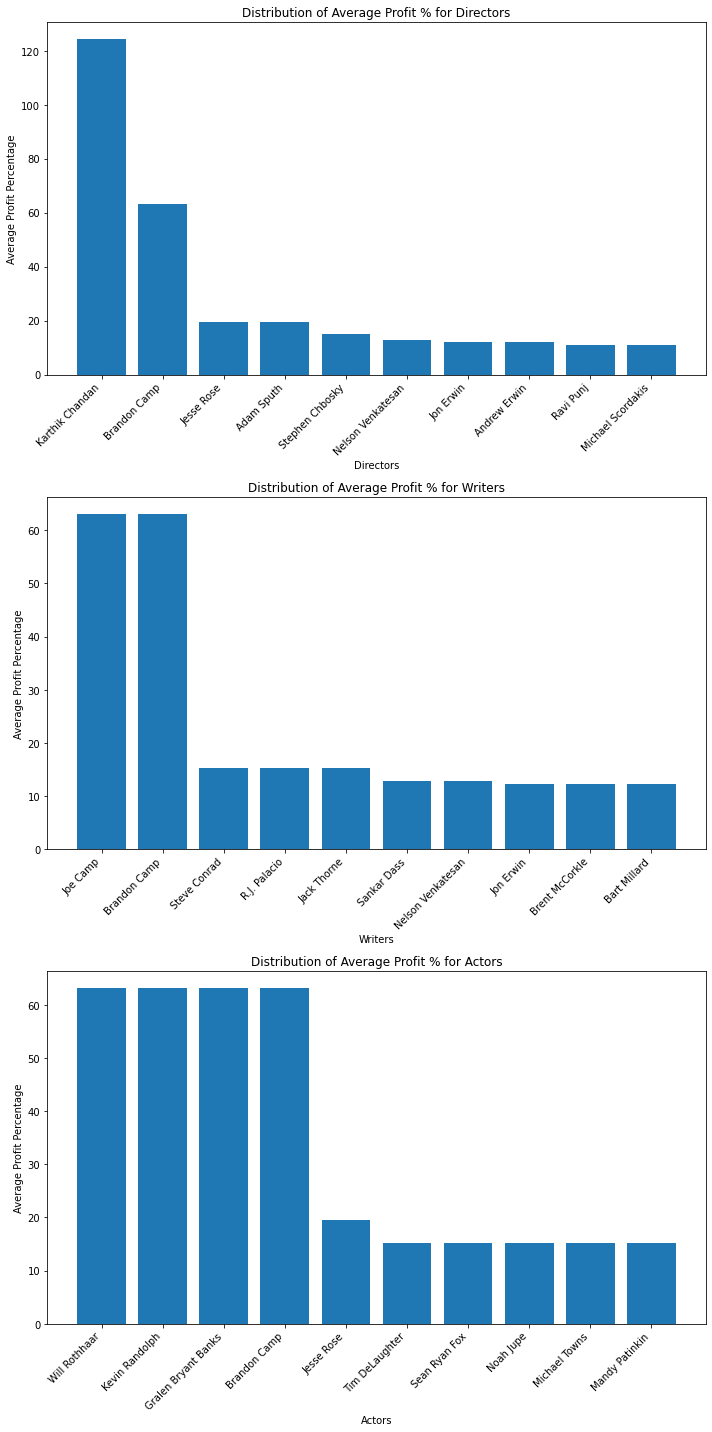

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(10, 20))

# Histogram for directors
ax1.bar(data=directors, x=directors['director'], height=directors['average_profit_perc'])
ax1.set_xticks(range(len(directors['director'])))
ax1.set_xticklabels(directors['director'], rotation=45, ha='right')
ax1.set_xlabel('Directors')
ax1.set_ylabel('Average Profit Percentage')
ax1.set_title('Distribution of Average Profit % for Directors')

# Histogram for writers
ax2.bar(data=writers, x=writers['writer'], height=writers['average_profit_perc'])
ax2.set_xticks(range(len(writers['writer'])))
ax2.set_xticklabels(writers['writer'], rotation=45, ha='right')
ax2.set_xlabel('Writers')
ax2.set_ylabel('Average Profit Percentage')
ax2.set_title('Distribution of Average Profit % for Writers')

# Histogram for actors
ax3.bar(data=actors, x=actors['actor'], height=actors['average_profit_perc'])
ax3.set_xticks(range(len(actors['actor'])))
ax3.set_xticklabels(actors['actor'], rotation=45, ha='right')
ax3.set_xlabel('Actors')
ax3.set_ylabel('Average Profit Percentage')
ax3.set_title('Distribution of Average Profit % for Actors')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

### Industry Profitiablilty and Budget by Year

grouping by year and looking at some profitability metrics

In [11]:
box_office_mojo_groupby_year = pd.read_sql("""

SELECT year, 
        SUM(domestic_gross) AS total_domestic_gross, 
        SUM(foreign_gross) AS total_foreign_gross
FROM box_office_mojo
GROUP BY year

""", conn)

box_office_mojo_groupby_year

,year,total_domestic_gross,total_foreign_gross
0,2010,1.015274e+10,1.436937e+10
1,2011,9.915690e+09,1.566287e+10
2,2012,1.069786e+10,1.700298e+10
3,2013,1.055885e+10,1.658024e+10
4,2014,1.014798e+10,1.695667e+10
5,2015,1.074487e+10,1.515435e+10
6,2016,1.086969e+10,1.898139e+10
7,2017,1.051677e+10,1.992893e+10
8,2018,1.076436e+10,1.747449e+10


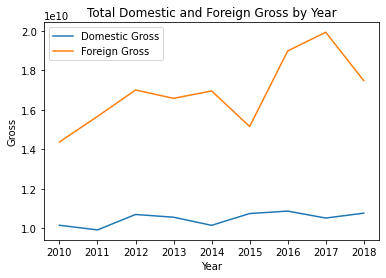

In [12]:
# Plot the data as a line graph
plt.plot(box_office_mojo_groupby_year['year'], box_office_mojo_groupby_year['total_domestic_gross'], label='Domestic Gross')
plt.plot(box_office_mojo_groupby_year['year'], box_office_mojo_groupby_year['total_foreign_gross'], label='Foreign Gross')

# Set the labels and title
plt.xlabel('Year')
plt.ylabel('Gross')
plt.title('Total Domestic and Foreign Gross by Year')

# Add a legend
plt.legend()

# Display the plot
plt.show()

In [13]:
movie_basics_groupby_year = pd.read_sql("""

SELECT m.start_year,
                COUNT(m.genres) AS genre_count,
                AVG(CAST(REPLACE(REPLACE(t.worldwide_gross, '$', ''), ',', '') AS INT)) AS average_worldwide_gross,
                AVG(CAST(REPLACE(REPLACE(t.production_budget, '$', ''), ',', '') AS INT)) AS average_production_budget,
                AVG(CAST(REPLACE(REPLACE(t.worldwide_gross, '$', ''), ',', '') AS INT)) / 
                AVG(CAST(REPLACE(REPLACE(t.production_budget, '$', ''), ',', '') AS INT)) AS average_profit_perc
FROM movie_basics AS m
JOIN tn_movie_budgets AS t
        ON m.primary_title = t.movie
GROUP BY m.start_year

""", conn)

movie_basics_groupby_year

,start_year,genre_count,average_worldwide_gross,average_production_budget,average_profit_perc
0,2010,352,9.266885e+07,3.296624e+07,2.811023
1,2011,393,9.568334e+07,3.417800e+07,2.799559
2,2012,378,9.840677e+07,3.355199e+07,2.932963
3,2013,395,9.066837e+07,3.255225e+07,2.785318
4,2014,458,8.635058e+07,2.858423e+07,3.020917
5,2015,457,7.426570e+07,2.731386e+07,2.718975
6,2016,394,1.010288e+08,3.341628e+07,3.023340
7,2017,367,1.044480e+08,3.652808e+07,2.859390
8,2018,343,1.228439e+08,3.663125e+07,3.353528
9,2019,185,7.307353e+07,3.241184e+07,2.254532


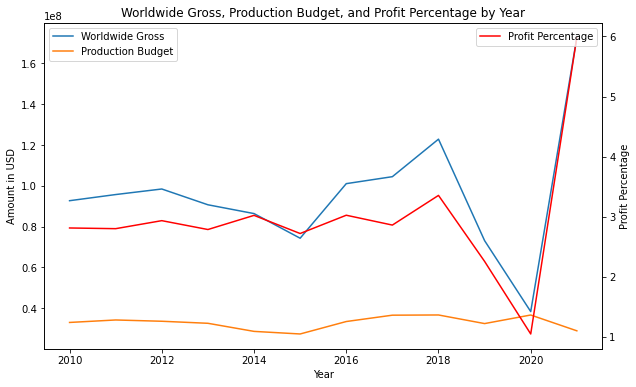

In [14]:
df = movie_basics_groupby_year

# Set the figure size
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the worldwide gross and production budget on the first y-axis
ax1.plot(df['start_year'], df['average_worldwide_gross'], label='Worldwide Gross')
ax1.plot(df['start_year'], df['average_production_budget'], label='Production Budget')
ax1.set_xlabel('Year')
ax1.set_ylabel('Amount in USD')

# Create a secondary y-axis for profit percentage
ax2 = ax1.twinx()
ax2.plot(df['start_year'], df['average_profit_perc'], color='red', label='Profit Percentage')
ax2.set_ylabel('Profit Percentage')

# Set the title
plt.title('Worldwide Gross, Production Budget, and Profit Percentage by Year')

# Add legends for both y-axes
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Display the plot
plt.show()

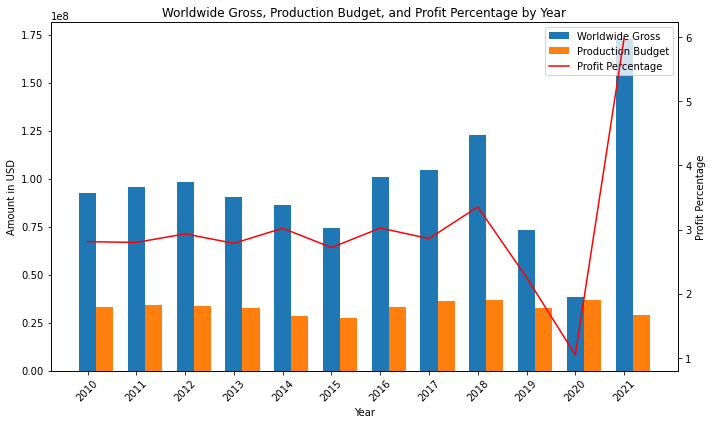

In [15]:
df = movie_basics_groupby_year

# Set the figure size
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the worldwide gross and production budget as side-by-side bars
bar_width = 0.35
year = df['start_year']
gross = df['average_worldwide_gross']
budget = df['average_production_budget']

ax1.bar(year, gross, width=bar_width, label='Worldwide Gross')
ax1.bar(year + bar_width, budget, width=bar_width, label='Production Budget')

# Create a secondary y-axis for profit percentage
ax2 = ax1.twinx()
ax2.plot(year, df['average_profit_perc'], color='red', label='Profit Percentage')

# Set the labels and title
ax1.set_xlabel('Year')
ax1.set_ylabel('Amount in USD')
ax2.set_ylabel('Profit Percentage')
plt.title('Worldwide Gross, Production Budget, and Profit Percentage by Year')

# # Combine the legends for both axes
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
combined_handles = handles1 + handles2
combined_labels = labels1 + labels2
ax1.legend(combined_handles, combined_labels, loc='upper right')

# Set the x-axis tick labels
ax1.set_xticks(year)
ax1.set_xticklabels(year, rotation=45)

# Adjust the layout to prevent overlapping of labels
plt.tight_layout()

# Display the plot
plt.show()

In [16]:
movie_basics_groupby_year['average_production_budget'].mean()

32800949.866458755

### Profit by Month

group profit and budget totals by Month and graph


In [17]:
# Execute the SQL query and retrieve the results into a DataFrame
movie_basics_groupby_month = pd.read_sql("""
    SELECT substr(t.release_date, 1, 3) AS month,
        AVG(CAST(REPLACE(REPLACE(t.worldwide_gross, '$', ''), ',', '') AS INT)) AS average_worldwide_gross,
        AVG(CAST(REPLACE(REPLACE(t.production_budget, '$', ''), ',', '') AS INT)) AS average_production_budget,
        AVG(CAST(REPLACE(REPLACE(t.worldwide_gross, '$', ''), ',', '') AS INT)) / 
                    AVG(CAST(REPLACE(REPLACE(t.production_budget, '$', ''), ',', '') AS INT)) AS average_profit_perc
    FROM tn_movie_budgets AS t
    GROUP BY month
    ORDER BY CASE month
        WHEN 'Jan' THEN 1
        WHEN 'Feb' THEN 2
        WHEN 'Mar' THEN 3
        WHEN 'Apr' THEN 4
        WHEN 'May' THEN 5
        WHEN 'Jun' THEN 6
        WHEN 'Jul' THEN 7
        WHEN 'Aug' THEN 8
        WHEN 'Sep' THEN 9
        WHEN 'Oct' THEN 10        WHEN 'Nov' THEN 11
        WHEN 'Dec' THEN 12
        ELSE 999
    END;
""", conn)

movie_basics_groupby_month

,month,average_worldwide_gross,average_production_budget,average_profit_perc
0,Jan,4.656382e+07,2.084349e+07,2.233974
1,Feb,7.154453e+07,2.804642e+07,2.550933
2,Mar,8.063337e+07,3.078208e+07,2.619491
3,Apr,5.992026e+07,2.380283e+07,2.517359
4,May,1.622680e+08,4.713520e+07,3.442608
5,Jun,1.425230e+08,4.309912e+07,3.306866
6,Jul,1.409636e+08,4.254616e+07,3.313193
7,Aug,6.097841e+07,2.555609e+07,2.386061
8,Sep,4.669369e+07,2.181290e+07,2.140645
9,Oct,4.946456e+07,2.039266e+07,2.425606


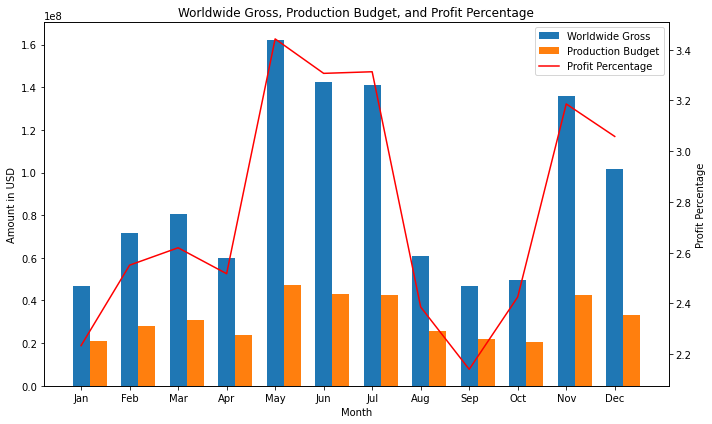

In [18]:
import numpy as np
df = movie_basics_groupby_month

# Set the figure size
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the worldwide gross and production budget as side-by-side bars
bar_width = 0.35
month = np.arange(len(df['month']))
gross = df['average_worldwide_gross']
budget = df['average_production_budget']

ax1.bar(month, gross, width=bar_width, label='Worldwide Gross')
ax1.bar(month + bar_width, budget, width=bar_width, label='Production Budget')

# Create a secondary y-axis for profit percentage
ax2 = ax1.twinx()
ax2.plot(month, df['average_profit_perc'], color='red', label='Profit Percentage')

# Set the labels and title
ax1.set_xlabel('Month')
ax1.set_ylabel('Amount in USD')
ax2.set_ylabel('Profit Percentage')
plt.title('Worldwide Gross, Production Budget, and Profit Percentage')

# Set the x-axis tick labels
ax1.set_xticks(month)
ax1.set_xticklabels(df['month'])


# Combine the legends for both axes
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
combined_handles = handles1 + handles2
combined_labels = labels1 + labels2
ax1.legend(combined_handles, combined_labels, loc='upper right')

# Adjust the layout to prevent overlapping of labels
plt.tight_layout()

# Display the plot
plt.show()

It appears that worldwide movie Gross Revenue surges twice during the year: May-June-Jul and Nov-Dec, 
corresponding to the early summer months and the holiday season

### Profit by Month of Year, only for movies with "Family" as one of the genres

In [19]:
# Execute the SQL query and retrieve the results into a DataFrame
movie_basics_groupby_month_family = pd.read_sql("""
    SELECT substr(t.release_date, 1, 3) AS month,
        AVG(CAST(REPLACE(REPLACE(t.worldwide_gross, '$', ''), ',', '') AS INT)) AS average_worldwide_gross,
        AVG(CAST(REPLACE(REPLACE(t.production_budget, '$', ''), ',', '') AS INT)) AS average_production_budget,
        AVG(CAST(REPLACE(REPLACE(t.worldwide_gross, '$', ''), ',', '') AS INT)) / 
                    AVG(CAST(REPLACE(REPLACE(t.production_budget, '$', ''), ',', '') AS INT)) AS average_profit_perc
    FROM tn_movie_budgets AS t
    JOIN movie_basics AS m
        ON t.movie = m.primary_title
    WHERE m.genres LIKE '%Family%'
    GROUP BY month
    ORDER BY CASE month
        WHEN 'Jan' THEN 1
        WHEN 'Feb' THEN 2
        WHEN 'Mar' THEN 3
        WHEN 'Apr' THEN 4
        WHEN 'May' THEN 5
        WHEN 'Jun' THEN 6
        WHEN 'Jul' THEN 7
        WHEN 'Aug' THEN 8
        WHEN 'Sep' THEN 9
        WHEN 'Oct' THEN 10        WHEN 'Nov' THEN 11
        WHEN 'Dec' THEN 12
        ELSE 999
    END;
""", conn)

movie_basics_groupby_month_family

,month,average_worldwide_gross,average_production_budget,average_profit_perc
0,Jan,6.016560e+07,3.777778e+07,1.592619
1,Feb,7.584884e+07,2.944785e+07,2.575700
2,Mar,2.878402e+08,7.656464e+07,3.759440
3,Apr,7.142240e+07,2.055714e+07,3.474335
4,May,2.894731e+08,1.043818e+08,2.773214
5,Jun,1.630996e+08,4.335714e+07,3.761769
6,Jul,1.321625e+08,5.318750e+07,2.484841
7,Aug,3.647679e+07,1.802500e+07,2.023678
8,Sep,1.206408e+08,4.103333e+07,2.940069
9,Oct,5.496249e+07,2.908250e+07,1.889882


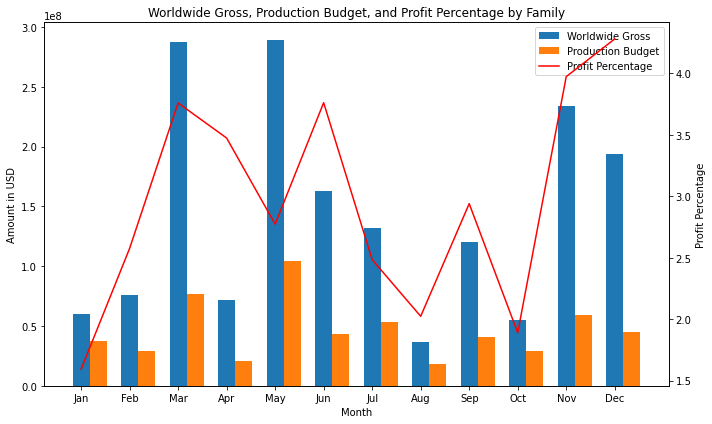

In [20]:
import numpy as np
df = movie_basics_groupby_month_family

# Set the figure size
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the worldwide gross and production budget as side-by-side bars
bar_width = 0.35
month = np.arange(len(df['month']))
gross = df['average_worldwide_gross']
budget = df['average_production_budget']

ax1.bar(month, gross, width=bar_width, label='Worldwide Gross')
ax1.bar(month + bar_width, budget, width=bar_width, label='Production Budget')

# Create a secondary y-axis for profit percentage
ax2 = ax1.twinx()
ax2.plot(month, df['average_profit_perc'], color='red', label='Profit Percentage')

# Set the labels and title
ax1.set_xlabel('Month')
ax1.set_ylabel('Amount in USD')
ax2.set_ylabel('Profit Percentage')
plt.title('Worldwide Gross, Production Budget, and Profit Percentage by Family')

# Set the x-axis tick labels
ax1.set_xticks(month)
ax1.set_xticklabels(df['month'])

# Combine the legends for both axes
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
combined_handles = handles1 + handles2
combined_labels = labels1 + labels2
ax1.legend(combined_handles, combined_labels, loc='upper right')

# Adjust the layout to prevent overlapping of labels
plt.tight_layout()

# Display the plot
plt.show()

### Histogram: distribution of Movie runtimes



In [21]:
df = pd.read_sql("""

SELECT runtime_minutes,
        (CAST(REPLACE(REPLACE(t.worldwide_gross, '$', ''), ',', '') AS INT)) AS worldwide_gross,
        (CAST(REPLACE(REPLACE(t.production_budget, '$', ''), ',', '') AS INT)) AS production_budget,
        (CAST(REPLACE(REPLACE(t.worldwide_gross, '$', ''), ',', '') AS INT)) / 
                    (CAST(REPLACE(REPLACE(t.production_budget, '$', ''), ',', '') AS INT)) AS profit_perc
    FROM tn_movie_budgets AS t
    JOIN movie_basics AS m
        ON t.movie = m.primary_title

""", conn)

df

,runtime_minutes,worldwide_gross,production_budget,profit_perc
0,93.0,2776345279,425000000,6
1,136.0,1045663875,410600000,2
2,113.0,149762350,350000000,0
3,141.0,1403013963,330600000,4
4,149.0,2048134200,300000000,6
...,...,...,...,...
3810,93.0,94596,10000,9
3811,NaN,527,10000,0
3812,95.0,4584,9000,0
3813,77.0,0,7000,0


/Users/nechamaborisute/anaconda3/envs/learn-env/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/nechamaborisute/anaconda3/envs/learn-env/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


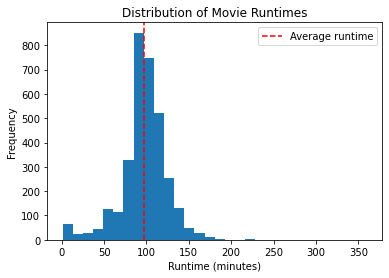

In [22]:
# Create a histogram
plt.hist(df['runtime_minutes'], bins=30)
plt.axvline(df['runtime_minutes'].mean(), color='red', linestyle='--', label = 'Average runtime')
plt.xlabel('Runtime (minutes)')
plt.ylabel('Frequency')
plt.title('Distribution of Movie Runtimes')
plt.legend()
plt.show()

### Gross Revenue by Runtime

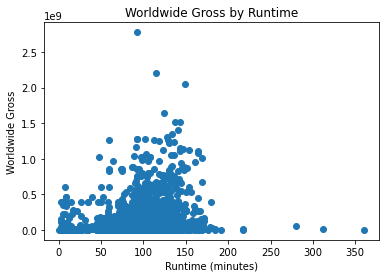

In [23]:
# Create a scatter plot
plt.scatter(df['runtime_minutes'], df['worldwide_gross'])
plt.xlabel('Runtime (minutes)')
plt.ylabel('Worldwide Gross')
plt.title('Worldwide Gross by Runtime')
plt.show()

In [24]:
df['runtime_minutes'].mean()

97.20462740384616

In [25]:
df['runtime_minutes'].median()

98.0

Average Runtime is about 100 minutes and so is the median. That is indicative of a strong recommendation.

# TOP COUNT BY STUDIO

In [26]:
pd.read_sql("""
    SELECT COUNT(title) AS total_count, studio,  production_budget, worldwide_gross
    FROM box_office_mojo AS b
    JOIN tn_movie_budgets AS t
        ON b.title = t.movie
        
    GROUP BY studio
    ORDER BY total_count DESC
    LIMIT 25
""", conn)

,total_count,studio,production_budget,worldwide_gross
0,117,Uni.,"$69,000,000","$543,464,573"
1,108,Fox,"$155,000,000","$418,186,950"
2,100,WB,"$160,000,000","$835,524,642"
3,74,Sony,"$40,000,000","$351,774,938"
4,72,Par.,"$170,000,000","$621,156,389"
5,70,BV,"$200,000,000","$1,068,879,522"
6,54,LGF,"$82,000,000","$268,268,174"
7,38,Wein.,"$1,000,000","$16,566,240"
8,36,WB (NL),"$95,000,000","$294,680,778"
9,36,FoxS,"$13,000,000","$331,266,710"


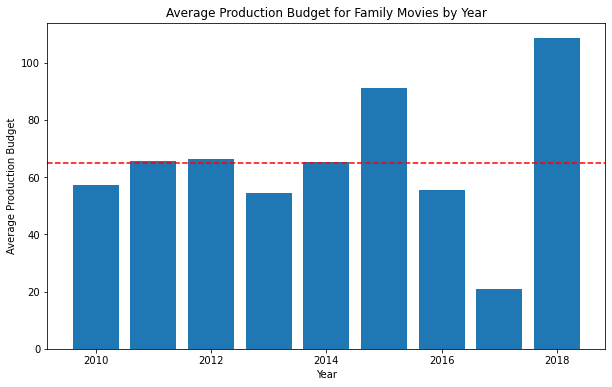

In [27]:
df = pd.read_sql("""
WITH RECURSIVE split(genre, str) AS (
    SELECT '', genres || ',' FROM movie_basics
    UNION ALL SELECT
    substr(str, 0, instr(str, ',')),
    substr(str, instr(str, ',')+1)
    FROM split WHERE str!=''
) 
SELECT AVG(CAST(REPLACE(production_budget, '$', '') AS INTEGER)) AS avg_production_budget, 
                worldwide_gross,
                year
FROM split
JOIN movie_basics AS m ON instr(genres, genre) > 0
JOIN tn_movie_budgets AS t ON m.primary_title = t.movie
JOIN box_office_mojo AS b ON b.title = t.movie
WHERE genre ='Family' 
GROUP BY year
ORDER BY year;
""", conn)


fig, ax = plt.subplots(figsize=(10, 6))

plt.bar(x = df['year'], height = df['avg_production_budget'])
plt.axhline(df['avg_production_budget'].mean(), color='red', linestyle='--')
plt.xlabel('Year')
plt.ylabel('Average Production Budget')
plt.title('Average Production Budget for Family Movies by Year')
plt.show()

In [28]:
df['avg_production_budget'].mean()

65.00117845117845

# AVERAGE PRODUCTION BUDGETS AND WORLDWIDE GROSS COMPARISONS

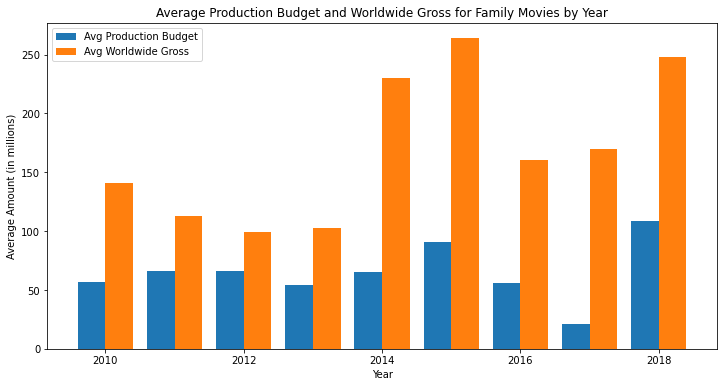

In [29]:
df = pd.read_sql("""
WITH RECURSIVE split(genre, str) AS (
    SELECT '', genres || ',' FROM movie_basics
    UNION ALL SELECT
    substr(str, 0, instr(str, ',')),
    substr(str, instr(str, ',')+1)
    FROM split WHERE str!=''
) 
SELECT AVG(CAST(REPLACE(production_budget, '$', '') AS INTEGER)) AS avg_production_budget,
       AVG(CAST(REPLACE(worldwide_gross, '$', '') AS INTEGER)) AS avg_worldwide_gross,
       year
FROM split
JOIN movie_basics AS m ON instr(genres, genre) > 0
JOIN tn_movie_budgets AS t ON m.primary_title = t.movie
JOIN box_office_mojo AS b ON b.title = t.movie
WHERE genre ='Family' 
GROUP BY year
ORDER BY year;

""", conn)

# Plotting the data
plt.figure(figsize=(12, 6))

# Double bar graph
plt.bar(df['year'] - 0.2, df['avg_production_budget'], width=0.4, label='Avg Production Budget')
plt.bar(df['year'] + 0.2, df['avg_worldwide_gross'], width=0.4, label='Avg Worldwide Gross' )

plt.xlabel('Year')
plt.ylabel('Average Amount (in millions)')
plt.title('Average Production Budget and Worldwide Gross for Family Movies by Year')
plt.legend()
plt.show()

In [30]:
pd.read_sql("""
WITH RECURSIVE split(genre, str) AS (
    SELECT '', genres || ',' FROM movie_basics
    UNION ALL SELECT
    substr(str, 0, instr(str, ',')),
    substr(str, instr(str, ',')+1)
    FROM split WHERE str!=''
) 
SELECT studio,
       COUNT(studio) AS total_movies,
       AVG(CAST(REPLACE(production_budget, '$', '') AS INTEGER)) AS avg_production_budget,
       AVG(CAST(REPLACE(worldwide_gross, '$', '') AS INTEGER)) AS avg_worldwide_gross
FROM (
    SELECT studio,
           CAST(REPLACE(production_budget, '$', '') AS INTEGER) AS production_budget,
           CAST(REPLACE(worldwide_gross, '$', '') AS INTEGER) AS worldwide_gross
    FROM split
    JOIN movie_basics AS m ON instr(genres, genre) > 0
    JOIN tn_movie_budgets AS t ON m.primary_title = t.movie
    JOIN box_office_mojo AS b ON b.title = t.movie
    WHERE genre ='Family' 
) AS filtered_data
GROUP BY studio
ORDER BY total_movies DESC;  



""", conn)
#NEED TO FIX MOVIE COUNT // SORT NOT WORKING ANYMORE

,studio,total_movies,avg_production_budget,avg_worldwide_gross
0,Fox,105859,54.941176,135.176471
1,BV,105859,107.470588,232.058824
2,Sony,43589,55.142857,244.142857
3,WB,31135,101.600000,213.800000
4,Uni.,24908,47.250000,301.000000
5,LGF,24908,15.250000,95.750000
6,Par.,18681,118.000000,187.666667
7,TriS,12454,15.500000,60.000000
8,MNE,12454,32.500000,23.000000
9,Wein.,6227,8.000000,68.000000


In [31]:
# close connection to database
conn.close()

## Results 



> Genre: Family 

> Release date period: Holidays (November - December)

>Director, Writer, Actor: Brandon Camp

>Runtime for movie: 1 hour 40 minutes

>Production Budget:  $65 Million